In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from dotenv import load_dotenv

2025-03-16 07:03:05.016076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 07:03:05.039377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 07:03:05.048947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742101385.069156   52830 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742101385.074021   52830 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742101385.120570   52830 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
tf.config.threading.set_intra_op_parallelism_threads(8)

In [3]:
load_dotenv()

True

In [4]:
TRAIN_REAL_PATH = os.getenv("TRAIN_REAL_PATH")
TRAIN_FAKE_PATH = os.getenv("TRAIN_FAKE_PATH")
TEST_FAKE_PATH = os.getenv("TEST_FAKE_PATH")
TEST_REAL_PATH = os.getenv("TEST_REAL_PATH")

print("TRAIN_REAL_PATH:", TRAIN_REAL_PATH)
print("TRAIN_FAKE_PATH:", TRAIN_FAKE_PATH)
print("TEST_REAL_PATH:", TEST_REAL_PATH)
print("TEST_FAKE_PATH:", TEST_FAKE_PATH)


train_real_images = np.array([cv2.imread(TRAIN_REAL_PATH+'/'+file) for file in os.listdir(TRAIN_REAL_PATH)])
train_fake_images = np.array([cv2.imread(TRAIN_FAKE_PATH+'/'+file) for file in os.listdir(TRAIN_FAKE_PATH)])
test_fake_images = np.array([cv2.imread(TEST_FAKE_PATH+'/'+file) for file in os.listdir(TEST_FAKE_PATH)])
test_real_images = np.array([cv2.imread(TEST_REAL_PATH+'/'+file) for file in os.listdir(TEST_REAL_PATH)])

TRAIN_REAL_PATH: /home/anubis/Downloads/archive/train/REAL/
TRAIN_FAKE_PATH: /home/anubis/Downloads/archive/train/FAKE/
TEST_REAL_PATH: /home/anubis/Downloads/archive/test/REAL/
TEST_FAKE_PATH: /home/anubis/Downloads/archive/test/FAKE/


In [5]:
train_real_images = train_real_images / 255.0
train_fake_images = train_fake_images / 255.0
test_real_images = test_real_images / 255.0
test_fake_images = test_fake_images / 255.0

In [20]:
train_images = np.concatenate((train_real_images, train_fake_images), axis=0)
test_images = np.concatenate((test_real_images, test_fake_images), axis=0)
train_labels = np.concatenate((np.zeros(len(train_real_images)), np.ones(len(train_fake_images))), axis=0)
test_labels = np.concatenate((np.zeros(len(test_real_images)), np.ones(len(test_fake_images))), axis=0)

In [21]:
train_shuffle = np.random.permutation(len(train_images))
test_shuffle = np.random.permutation(len(test_images))

train_images = train_images[train_shuffle]
train_labels = train_labels[train_shuffle]
test_images = test_images[test_shuffle]
test_labels = test_labels[test_shuffle]

In [22]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32,32,3), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/home/anubis/projects/ITFest2025/Server/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    x=train_images,
    y=train_labels,
    validation_data=(val_images, val_labels),
    epochs=2,
    callbacks=[early_stopping],
    verbose=2,
    batch_size=32
)

Epoch 1/2


2025-03-16 07:52:29.371395: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


2500/2500 - 249s - 100ms/step - accuracy: 0.8788 - loss: 0.2860 - val_accuracy: 0.9008 - val_loss: 0.2510
Epoch 2/2
2500/2500 - 229s - 91ms/step - accuracy: 0.9301 - loss: 0.1814 - val_accuracy: 0.9066 - val_loss: 0.2303


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 983,685 (3.75 MB)

 Trainable params: 327,809 (1.25 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 655,620 (2.50 MB)

None


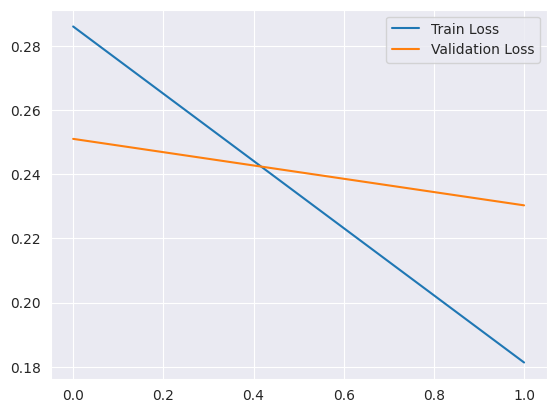

In [27]:
print(model.summary())

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [28]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.0962 - loss: 4.1956
Test Loss: 4.197640895843506
Test Accuracy: 0.09510000050067902


625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step


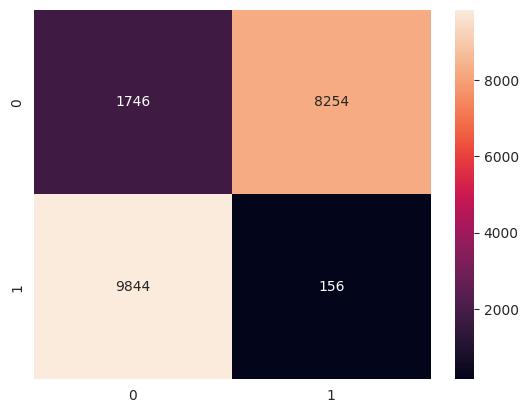

In [29]:
y_pred = model.predict(test_images)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [30]:
model.save("deepfake_model32_rebrand.keras")